In [1]:
import pandas as pd
import numpy as np

import os

import networkx as nx

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV


import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from stellargraph import globalvar

from tensorflow.keras import layers, optimizers, losses, metrics, Model,models, regularizers

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns

import itertools

from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Reading the csv file of dataset and weight matrix
adjacency=pd.read_csv('adjacency.csv')

df_numeric = pd.read_csv('data_numeric_norm.csv')
df_target=pd.read_csv('data_target.csv')

# Create the Graph

In [3]:
#Make df_numeric to DataFrame
df_numeric=pd.DataFrame(df_numeric)

In [4]:
#Create graph G with weight matrix
G = nx.Graph(np.matrix(adjacency))

In [5]:
#Some info about graph G
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1850
Number of edges: 885478
Average degree: 957.2735


In [6]:
#Check if the graph is connected
print(nx.is_connected(G))

True


In [7]:
#Edges with their weight on DataFrame table
edges_table = pd.DataFrame(G.edges(data=True), columns=['source','target','weight'])

In [8]:
#See few rows of new DataFrame
edges_table.head(3)

,source,target,weight
0,0,0,{'weight': 1}
1,0,1,{'weight': 1}
2,0,2,{'weight': 1}


In [9]:
df_numeric.index.values

array([   0,    1,    2, ..., 1847, 1848, 1849], dtype=int64)

In [10]:
#Convert DataFrame df_numeric to array
df_features=np.array(df_numeric)

In [11]:
#Number of nodes will be connected to coresponding feature
node_data=zip(df_numeric.index.values,df_features)
node_data

In [12]:
#Creating StellarGraph with G and features
Gs=sg.StellarGraph(G,node_features=node_data)

C:\Anaconda3\envs\leila-gpu\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  


In [13]:
#Check if Gs has all properties
print(Gs.info())

StellarGraph: Undirected multigraph
 Nodes: 1850, Edges: 885478

 Node types:
  default: [1850]
    Features: float32 vector, length 38
    Edge types: default-default->default

 Edge types:
    default-default->default: [885478]
        Weights: all 1 (default)
        Features: none


# Splitting the data to train and test

In [14]:
#Split the data to train and test (30% to 70%)
train_data, test_data, train_targets, test_targets = train_test_split(
    df_numeric, df_target, test_size=0.70, random_state=117
)
train_targets = train_targets.values
test_targets = test_targets.values
print("Sizes and class distributions for train/test data")
print("Shape train_data {}".format(train_data.shape))
print("Shape test_data {}".format(test_data.shape))
print(
    "Train data number of 0s {} and 1s {}".format(
        np.sum(train_targets == 0), np.sum(train_targets == 1)
    )
)
print(
    "Test data number of 0s {} and 1s {}".format(
        np.sum(test_targets == 0), np.sum(test_targets == 1)
    )
)

Sizes and class distributions for train/test data
Shape train_data (555, 38)
Shape test_data (1295, 38)
Train data number of 0s 298 and 1s 257
Test data number of 0s 702 and 1s 593


# Dealing with imbalanced data

In [15]:
from sklearn.utils.class_weight import compute_class_weight
#Balance the classes by adjusting their weights
class_weights = compute_class_weight(
    "balanced", np.unique(train_targets), train_targets[:, 0])
train_class_weights = dict(zip(np.unique(train_targets), class_weights))

train_class_weights

C:\Anaconda3\envs\leila-gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1
 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0
 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0
 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0
 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0
 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0
 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1
 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0
 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0
 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1

{0: 0.9312080536912751, 1: 1.0797665369649805}

# Specify global parameters

In [17]:
#For GraphSAGE model
batch_size = 50
num_samples = [10,5]

#The number of training epochs
epochs = 200  

# Creating the base model

In [318]:
#Call GraphSAGENodeGenerator to generate data in the format used in keras
generator = GraphSAGENodeGenerator(Gs, batch_size, num_samples)

#Call flow method to generate data that model will be train on them
train_gen = generator.flow(train_data.index, train_targets, shuffle=True)

In [319]:
#Create two hidden layers for GraphSAGE model 
base_model = GraphSAGE(
        layer_sizes=[50,50], generator=generator, bias=True, dropout=0.3)

#Expose the input and output tensors of the GraphSAGE model for node prediction
x_inp, x_out = base_model.in_out_tensors()

#Dense layer to predict on train data
prediction = layers.Dense(units=1, activation="sigmoid")(x_out)

In [320]:
#Create the model with input and predicted result 
model = Model(inputs=x_inp, outputs=prediction)

In [321]:
#Optimise the model
model.compile(
    optimizer=optimizers.Adam(lr=0.005), loss=losses.binary_crossentropy, metrics=["acc"])


In [322]:

model

In [323]:
#Generate new data for testing 
test_gen = generator.flow(test_data.index, test_targets)

In [324]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Apply earlystopping; patience is the number of epochs to wait before early stopping in case of no further improvement 
if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [325]:
#Now we train the model
class_weight = train_class_weights
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    verbose=0,
    shuffle=False,
    class_weight=class_weights,
    callbacks=[es_callback, mc_callback],
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


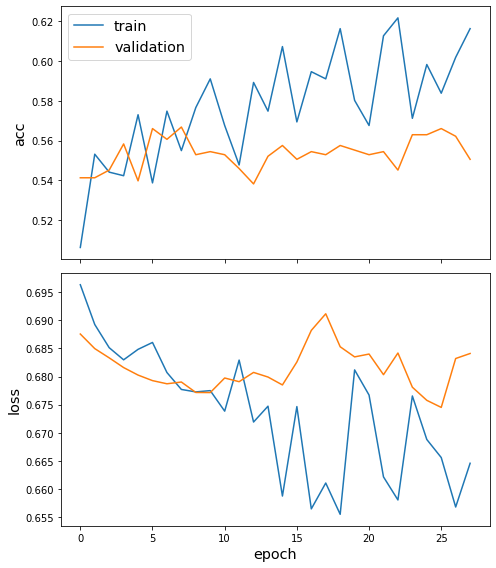

In [326]:
#Draw the history of evaluation
sg.utils.plot_history(history)

# Model evaluation

In [327]:
#Evaluate the model on testing data
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ...
    to  
  ['...']
26/26 [==============================] - 1s 32ms/step - loss: 0.6864 - acc: 0.5436

Test Set Metrics:
	loss: 0.6864
	acc: 0.5436


In [328]:
#Generate all nodes
all_nodes = df_numeric.index
all_gen = generator.flow(all_nodes)

In [303]:
#Predict model for all nodes
all_predictions = model.predict(all_gen).squeeze()[..., np.newaxis]

In [304]:
#Shape of the prediction 
all_predictions.shape

(1850, 1)

In [305]:
#Make prediction into DataFrame
all_predictions_df = pd.DataFrame(all_predictions, index=df_numeric.index)

In [306]:
#Evaluate label for test data
test_preds = all_predictions_df.loc[test_data.index, :]

In [307]:
test_preds.shape

(1295, 1)

In [308]:
test_preds.head(10)

,0
1307,0.342054
865,0.487152
42,0.353852
47,0.299058
805,0.495435
1150,0.296007
233,0.366739
516,0.297516
837,0.438978
173,0.472015


# Evaluate Metrics

In [309]:
#Calculate AUC for test data
test_predictions = test_preds.values
test_predictions_class = ((test_predictions > 0.5) * 1).flatten()
test_df = pd.DataFrame(
    {
        "Predicted_score": test_predictions.flatten(),
        "Predicted_class": test_predictions_class,
        "True": test_targets[:, 0],
    }
)
roc_auc = metrics.roc_auc_score(test_df["True"].values, test_df["Predicted_score"].values)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.5781938378902967


In [310]:
#Create confusion matrix
pd.crosstab(test_df["True"], test_df["Predicted_class"])

Predicted_class,0,1
True,,
0,578,124
1,431,162


In [311]:
#Extract classification report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_df["True"],test_df["Predicted_class"]))

              precision    recall  f1-score   support

           0       0.57      0.82      0.68       702
           1       0.57      0.27      0.37       593

    accuracy                           0.57      1295
   macro avg       0.57      0.55      0.52      1295
weighted avg       0.57      0.57      0.54      1295



In [312]:
#Calculate f1-score seperately
from sklearn.metrics import f1_score
f1_score(test_df["True"], test_df["Predicted_class"], average='macro')

0.5221144850724981

In [313]:
print("Misclassification error rate  :",round(np.mean(test_df["Predicted_class"]!=test_df["True"]),2))

Misclassification error rate  : 0.43


In [314]:
#Recall
from sklearn.metrics import recall_score
recall_score(test_df["True"], test_df["Predicted_class"], average='macro')

0.5482745035864767

In [315]:
#Precision
from sklearn.metrics import precision_score
precision_score(test_df["True"], test_df["Predicted_class"], average='macro')

0.5696389834149993

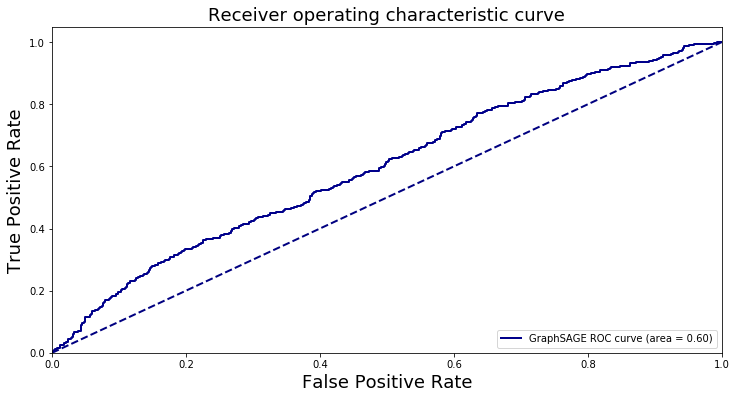

In [289]:
#Draw AUC
fpr, tpr, thresholds = metrics.roc_curve(
    test_df["True"], test_df["Predicted_score"], pos_label=1
)
plt.figure(figsize=(12, 6,))

lw = 2
plt.plot(
    fpr, tpr, color="darkblue", lw=lw, label="GraphSAGE ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Receiver operating characteristic curve", fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Visualisation of node embeddings

In [40]:
#To see the operation in each layer
model.layers

In [41]:
#Evaluate model on input data and output from layer 4 from end
emb_model = Model(inputs=x_inp, outputs=model.layers[-4].output)
emb = emb_model.predict(all_gen)

In [42]:
emb.shape

(1850, 1, 50)

In [43]:
emb = emb.squeeze()

In [44]:
emb_all_df = pd.DataFrame(emb, index=df_numeric.index)

In [45]:
emb_test = emb_all_df.loc[test_data.index, :]

In [46]:
X = emb_test
y = test_targets

In [47]:
transform = TSNE  
#Use PCA to change the embedding vector to only 2 dimension
trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(X), index=test_data.index)
emb_transformed["label"] = y

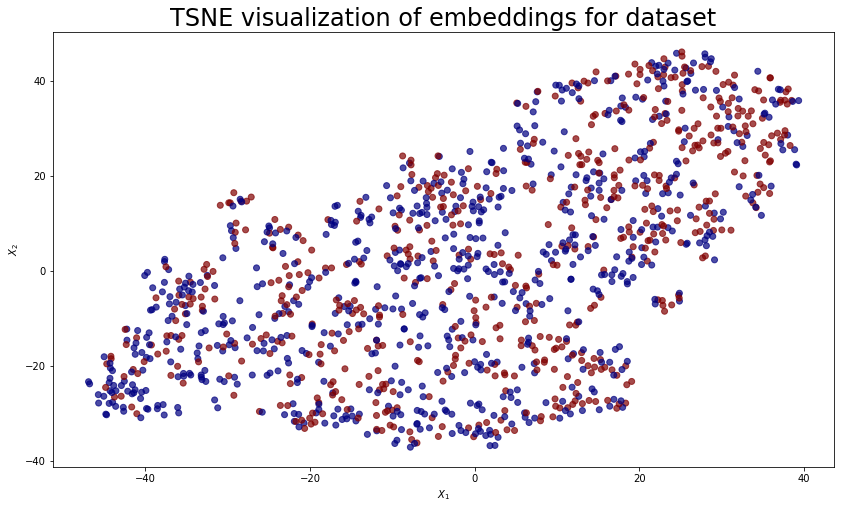

In [48]:
#Draw 2 dimension vectors representation
alpha = 0.7

fig, ax = plt.subplots(figsize=(14, 8,))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of embeddings for dataset".format(transform.__name__),
    fontsize=24,
)
plt.show()